In [25]:
import torch
import torch.nn as nn
from torch_cluster import radius_graph
from torch_cluster import radius
from torch_geometric.data import Batch
import matplotlib.pyplot as plt
from layers import FourierEmbedding
from utils.circle import minimum_enclosing_circle
from modules.encoder import QCNetEncoder
from torch_geometric.utils import dense_to_sparse
from layers.attention_layer import AttentionLayer
from utils.geometry import angle_between_2d_vectors

In [26]:
class Area_Attn(nn.Module):
    def __init__(self,
                 input_dim_anchor_pts=2,
                 head_num = 8,
                 anchor_query_hidden_dim=128,
                 anchor_area_query_num_freq_bands=64,
                 anchor_area_max_pts_num = 400,
                 dropout=0.1) -> None:
        super(Area_Attn,self).__init__()
        self.anchor_area_max_pts_num = anchor_area_max_pts_num
        self.input_dim_anchor_pts = input_dim_anchor_pts
        self.anchor_query_hidden_dim = anchor_query_hidden_dim
        self.anchor_area_query_num_freq_bands = anchor_area_query_num_freq_bands
        self.anchor_area_pos_embed = FourierEmbedding(input_dim=self.input_dim_anchor_pts, 
                                                       hidden_dim=self.anchor_query_hidden_dim, 
                                                       num_freq_bands=self.anchor_area_query_num_freq_bands)
        self.attn = nn.MultiheadAttention(self.anchor_query_hidden_dim,head_num,dropout)
        self.attn_postnorm = nn.LayerNorm(anchor_query_hidden_dim)
        self.query_content_mlp = nn.Linear(anchor_query_hidden_dim,anchor_query_hidden_dim)
        self.new_query_pos = nn.Linear(anchor_query_hidden_dim,input_dim_anchor_pts)

        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, 
                query_content:torch.Tensor, 
                query_pos:torch.Tensor, 
                agent_history_traj_feat:torch.Tensor,
                ):
        query_pos_shape = query_pos.shape
        query_pos = query_pos.view(-1, query_pos.size(-1))
        area_anchor_query_pos = self.anchor_area_pos_embed(continuous_inputs=query_pos,categorical_embs=None)
        area_anchor_query_pos = area_anchor_query_pos.view(-1, self.anchor_area_max_pts_num, self.anchor_query_hidden_dim)
        q_area_query = (area_anchor_query_pos +  query_content).permute(1,0,2)
        k_agent_history_traj_feat = v_agent_history_traj_feat = agent_history_traj_feat.permute(1,0,2)

        tmp,_ = self.attn(q_area_query, k_agent_history_traj_feat, v_agent_history_traj_feat)
        tmp = tmp.permute(1,0,2)
        query_content = self.attn_postnorm(query_content + tmp)
        new_query_content = self.attn_postnorm(self.query_content_mlp(query_content) + query_content)
        new_query_pos = query_pos.reshape(query_pos_shape) + self.relu(self.new_query_pos(new_query_content))

        return  new_query_content, new_query_pos
    
class Area_anchor_self_attn(nn.Module):
    def __init__(self,
                 input_dim_anchor_pts=2,
                 head_num = 8,
                 anchor_query_hidden_dim=128,
                 anchor_area_query_num_freq_bands=64,
                 anchor_area_max_pts_num = 400,
                 dropout=0.1) -> None:
        super(Area_anchor_self_attn, self).__init__()
        self.input_dim_anchor_pts = input_dim_anchor_pts
        self.anchor_query_hidden_dim = anchor_query_hidden_dim
        self.anchor_area_max_pts_num = anchor_area_max_pts_num
        self.anchor_area_query_num_freq_bands = anchor_area_query_num_freq_bands
        self.anchor_area_pos_embed = FourierEmbedding(input_dim=self.input_dim_anchor_pts, 
                                                       hidden_dim=self.anchor_query_hidden_dim, 
                                                       num_freq_bands=self.anchor_area_query_num_freq_bands)

        self.pos_embed_mlp = nn.Linear(anchor_query_hidden_dim,anchor_query_hidden_dim)
        self.self_attn = nn.MultiheadAttention(self.anchor_query_hidden_dim,head_num,dropout)
        self.attn_postnorm = nn.LayerNorm(anchor_query_hidden_dim)
        self.relu = nn.ReLU(inplace=True)

    def forward(self,
                query_content:torch.Tensor, 
                query_pos:torch.Tensor, ):   
        query_pos_shape = query_pos.shape
        query_pos_embed = query_pos.view(-1, query_pos.size(-1)) 
        query_pos_embed = self.anchor_area_pos_embed(query_pos_embed)
        query_pos_embed = query_pos_embed.view(query_pos_shape[0], query_pos_shape[1], -1)
        query_pos_embed = self.pos_embed_mlp(query_pos_embed)
        query_pos_embed = self.relu(query_pos_embed)
        
        q = k = query_content + query_pos_embed
        v = query_content
        tmp,_  = self.self_attn(q.permute(1,0,2),k.permute(1,0,2),v.permute(1,0,2))
        tmp = tmp.permute(1,0,2)
        new_query_content = self.attn_postnorm(tmp + query_content) 
        new_query_pos = query_pos
        return new_query_content, new_query_pos

In [27]:

class Area_anchor(nn.Module):
    def __init__(self,
                 dim=2,                                     # setting the geo dim in prediction
                 agent_feat_dim=4,                          # setting the num of agent input feature
                 self_attn_num_layers = 1,                  # setting the num of agent_self_attn
                 agent_query_hidden_dim=128,                # setting the num of query_hidden_dim used for anchor_query
                 history_steps=50,
                 time_span = None,
                 input_dim_anchor_pts=2,                    # setting the num of dim used for query_pos
                 anchor_query_hidden_dim=128,               # used like query_pos hidden dim 
                 anchor_query_num_freq_bands=64,            # used for query_pos fouri embed
                 anchor_area_query_num_freq_bands=64,       # used for agent_traj embed
                 agent2map_pts_max_length=400,              # setting the max num of anchor pts
                 agent_self_attn_num_head=8,                # setting agent_self_attn TR model's head
                 agent_self_attn_head_dim=16,               # setting agent_self_attn TR model's head dim hidden=head_num*head_dim
                 agent_self_attn_dropout=0.1,
                 agent_self_attn_fouri_embed=64,
                 query_pts_num=400
                 ) -> None:      
        super(Area_anchor, self).__init__()
        self.dim = dim
        self.query_pts_num = query_pts_num
        self.feat_dim = agent_query_hidden_dim
        self.self_attn_num_layers = self_attn_num_layers
        self.history_steps = history_steps
        self.agent2map_pts_max_length = agent2map_pts_max_length
        self.time_span = time_span if time_span is not None else history_steps
        self.query_pos = FourierEmbedding(input_dim=input_dim_anchor_pts, 
                                          hidden_dim=anchor_query_hidden_dim, 
                                          num_freq_bands=anchor_query_num_freq_bands)
        self.agent_self_pos_embed = FourierEmbedding(input_dim=dim, 
                                        hidden_dim=agent_query_hidden_dim, 
                                        num_freq_bands=agent_self_attn_fouri_embed)

        self.query_embed = nn.Parameter(torch.rand(self.agent2map_pts_max_length, self.feat_dim))
        self.type_agent_history_traj_emb =  nn.Embedding(10, agent_query_hidden_dim)
        self.agent_history_traj_emb = FourierEmbedding(input_dim=agent_feat_dim, hidden_dim=agent_query_hidden_dim, num_freq_bands=anchor_area_query_num_freq_bands)

        # setting agent_traj_self_attn
        self.self_attn_num_layers = self_attn_num_layers
        self.agent_traj_self_attn = nn.ModuleList(
            [AttentionLayer(hidden_dim=agent_query_hidden_dim, 
                            num_heads=agent_self_attn_num_head, 
                            head_dim=agent_self_attn_head_dim, 
                            dropout=agent_self_attn_dropout,
                            bipartite=False, has_pos_emb=True) for _ in range(self_attn_num_layers)])
        self.area_attn = Area_Attn(head_num=agent_self_attn_num_head)
        self.area_anchor_self_attn = Area_anchor_self_attn()

    def forward(self,data):
        init_anchor_pts = self.init_anchor_area(data, 
                                                self.history_steps, 
                                                self.dim, 
                                                self.agent2map_pts_max_length,
                                                relative_pos=False)
        init_area_anchor_query_content = self.query_embed.unsqueeze(0).repeat(data['agent']['num_nodes'],1,1)

        # ==============================agent_history_traj self_attn============================== #
        pos_a = data['agent']['position'][:, :self.history_steps, :self.dim].contiguous()
        motion_vector_a = torch.cat([pos_a.new_zeros(data['agent']['num_nodes'], 1, self.dim),pos_a[:, 1:] - pos_a[:, :-1]], dim=1)
        head_a = data['agent']['heading'][:, :self.history_steps].contiguous()
        head_vector_a = torch.stack([head_a.cos(), head_a.sin()], dim=-1)
        vel = data['agent']['velocity'][:, :self.history_steps, :self.dim].contiguous()
        agent_traj_feat = torch.stack( #agent_traj_feat shape: [agent_num, self.history_steps, self.dim]
            [torch.norm(motion_vector_a[:, :, :2], p=2, dim=-1),
                angle_between_2d_vectors(ctr_vector=head_vector_a, nbr_vector=motion_vector_a[:, :, :2]),
                torch.norm(vel[:, :, :2], p=2, dim=-1),
                angle_between_2d_vectors(ctr_vector=head_vector_a, nbr_vector=vel[:, :, :2])], dim=-1)  
        categorical_embs = [self.type_agent_history_traj_emb(data['agent']['type'].long()).repeat_interleave(repeats=self.history_steps,dim=0)]
        agent_traj_feat = self.agent_history_traj_emb(continuous_inputs=agent_traj_feat.view(-1, agent_traj_feat.size(-1)), categorical_embs=categorical_embs)
        agent_traj_feat = agent_traj_feat.view(-1, self.history_steps, self.feat_dim) # agent_traj_feat shape [agent_num,self.history_steps,self.feat_dim]
        
        # set timestep index
        mask = data['agent']['valid_mask'][:, :self.history_steps].contiguous()
        mask_t = mask.unsqueeze(2) & mask.unsqueeze(1)
        edge_index_t = dense_to_sparse(mask_t)[0]
        edge_index_t = edge_index_t[:, edge_index_t[1] > edge_index_t[0]]
        edge_index_t = edge_index_t[:, edge_index_t[1] - edge_index_t[0] <= self.time_span]
        
        # set pos_embed
        pos_t = pos_a.reshape(-1, self.dim) 
        rel_pos_t = pos_t[edge_index_t[0]] - pos_t[edge_index_t[1]]
        r_t = rel_pos_t[:, :2]
        r_t = self.agent_self_pos_embed(continuous_inputs=r_t, categorical_embs=None)
        for i in range(self.self_attn_num_layers):
            agent_traj_feat = agent_traj_feat.reshape(-1, self.feat_dim)
            agent_traj_feat = self.agent_traj_self_attn[i](agent_traj_feat, r_t, edge_index_t)
        
        agent_traj_feat = agent_traj_feat.reshape(-1,self.history_steps,self.feat_dim)
        # ======================================================================================== #

        # ====================================choose pred traj==================================== #
        pred_mask = data['agent']['predict_mask'].any(dim=-1, keepdim=True)
        init_area_anchor_query_content_need_pred = init_area_anchor_query_content[pred_mask.squeeze()]
        agent_traj_feat_need_pred = agent_traj_feat[pred_mask.squeeze()]
        init_anchor_pts_need_pred = init_anchor_pts[pred_mask.squeeze()]
        # ======================================================================================== #
        init_area_anchor_query_content_need_pred,init_anchor_pts_need_pred= self.area_anchor_self_attn(init_area_anchor_query_content_need_pred,
                                                                                                       init_anchor_pts_need_pred)
        _,new_query_pos = self.area_attn(query_content = init_area_anchor_query_content_need_pred,
                       query_pos = init_anchor_pts_need_pred,
                       agent_history_traj_feat = agent_traj_feat_need_pred)
        return new_query_pos, init_anchor_pts

    def init_anchor_area(self, data, history_steps, dim, query_pts_num=400, relative_pos=True):
        device = data['agent']['predict_mask'].device
        pred_mask = data['agent']['predict_mask'].any(dim=-1, keepdim=True)
        init_anchor_list = []
        
        for each_agent_idx in range(data['agent']['num_nodes']):
            if not pred_mask[each_agent_idx]:
                init_anchor_list.append(torch.zeros(query_pts_num, dim, device=device))
                continue
            
            ref = data['agent']['position'][each_agent_idx, history_steps, :dim].to(device)
            
            valid_history_steps = (data['agent']['position'][each_agent_idx, :history_steps, :dim].permute(1, 0) * 
                                data['agent']['valid_mask'][each_agent_idx, :history_steps]).permute(1, 0)
            valid_history_steps = valid_history_steps - ref
            proj_pred_pts = -valid_history_steps[data['agent']['valid_mask'][each_agent_idx, :history_steps]]
            
            try:
                tmp = proj_pred_pts.repeat(query_pts_num // proj_pred_pts.shape[0], 1).to(device)
                _, r = minimum_enclosing_circle(valid_history_steps[data['agent']['valid_mask'][each_agent_idx, :history_steps], :])
                tmp = (torch.cat((tmp, proj_pred_pts[:query_pts_num % proj_pred_pts.shape[0]]), dim=0) + 
                    torch.randn(query_pts_num, dim, device=device) * r * 0.1).to(device)
            except:
                r =torch.tensor([0.01]).to(device)
                tmp = torch.randn(query_pts_num,dim).to(device) * r
            
            if not relative_pos:
                tmp = (tmp + ref).to(device)
            init_anchor_list.append(tmp)
        
        init_anchor_pts = torch.stack(init_anchor_list, dim=0)
        return init_anchor_pts

In [28]:
import torch
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment
from scipy.spatial import ConvexHull

def hungarian_hausdorff_loss(pred_points, gt_points):
    num_pred_points = pred_points.size(0)
    num_gt_points = gt_points.size(0)
    
    if num_pred_points > num_gt_points:
        cost_matrix = torch.cdist(pred_points, gt_points, p=2).detach().cpu().numpy()
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        selected_pred_points = pred_points[row_ind]
    else:
        cost_matrix = torch.cdist(gt_points, pred_points, p=2).detach().cpu().numpy()
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        selected_pred_points = gt_points[col_ind]

    selected_pred_points = torch.tensor(selected_pred_points, requires_grad=True).to(pred_points.device)
    
    dists_A_to_B = torch.cdist(selected_pred_points, gt_points, p=2)
    min_dists_A_to_B = torch.min(dists_A_to_B, dim=1)[0]
    min_dists_B_to_A = torch.min(dists_A_to_B, dim=0)[0]
    hausdorff_dist = torch.max(torch.max(min_dists_A_to_B), torch.max(min_dists_B_to_A))
    
    return hausdorff_dist






class CustomLoss(nn.Module):
    def __init__(self, lambda_area=1.0):
        super(CustomLoss, self).__init__()
        self.lambda_area = lambda_area

    def forward(self, points_A, points_B):
        distribution_loss = self.compute_distribution_loss(points_A, points_B)
        area_loss = self.compute_area_loss(points_A)
        total_loss = distribution_loss + self.lambda_area * area_loss * 0.1
        return total_loss

    def compute_distribution_loss(self, points_A, points_B):
        dist_matrix = torch.cdist(points_A, points_B)
        min_dist, _ = dist_matrix.min(dim=1)
        return min_dist.mean()

    def compute_area_loss(self, points_A):
        points_A = points_A.detach().cpu().numpy()
        if len(points_A) < 3:  # ConvexHull requires at least 3 points
            return torch.tensor(0.0)
        hull = ConvexHull(points_A)
        return torch.tensor(hull.volume, requires_grad=True)

In [29]:
from dataset_prepare.argoverse_v2_dataset import ArgoverseV2Dataset
from torch_geometric.data import DataLoader
import numpy as np

dataset = ArgoverseV2Dataset('D:\\argoverse2', 'train', None, None, None)
loader = DataLoader(dataset,batch_size=4,shuffle=False)
device = torch.device('cuda')

testqc = Area_anchor().to(device)
optimizer = torch.optim.SGD(testqc.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = CustomLoss(lambda_area=0.1)
epoch = 40

min_loss = np.inf
best_model_path = 'C:\\Users\\Lenovo\\OneDrive - City University of Hong Kong - Student\\Desktop\\mikumiku\\mikumiku\\best_model.pth'

for ii in range(epoch):
    print(ii)
    
    for data,iii in zip(loader,range(len(loader))):
        loss = 0
        optimizer.zero_grad()
        pred,init_raw = testqc(data = data.to(device))
        pred_mask = data['agent']['predict_mask'].any(dim=-1, keepdim=True).squeeze()
        gt = data['agent']['position'][pred_mask,:,:]
        for each_pred,each_gt,i in zip(pred,gt,range(gt.shape[0])):
            each_gt = each_gt[50:,:][data['agent']['predict_mask'][pred_mask][i,50:],:2]
            try:
                loss += criterion(each_pred,each_gt)
            except:
                # print(each_pred)
                print(lalala)
                print(pred.shape)
                print(iii)
                print(i)
                raise ValueError('in')
        lalala = pred.shape[0]

        loss.backward()
        optimizer.step()
        # ====================================save best model param==================================== #
        if loss.item() < min_loss:
            min_loss = loss.item()
            torch.save(testqc.state_dict(), best_model_path)
    print(loss)

    

0
118
torch.Size([82, 400, 2])
1
57


ValueError: in

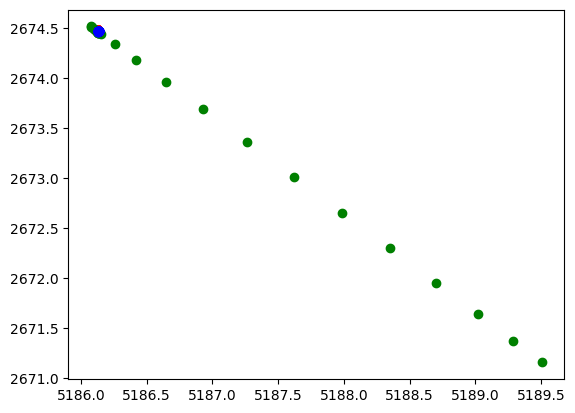

In [31]:
from dataset_prepare.argoverse_v2_dataset import ArgoverseV2Dataset
from torch_geometric.data import DataLoader
import numpy as np

dataset = ArgoverseV2Dataset('D:\\argoverse2', 'train', None, None, None)
loader = DataLoader(dataset,batch_size=4)
device = torch.device('cuda')

testqc = Area_anchor().to(device)

epoch = 40
min_loss = np.inf
best_model_path = 'C:\\Users\\Lenovo\\OneDrive - City University of Hong Kong - Student\\Desktop\\mikumiku\\mikumiku\\best_model.pth'

testqc.load_state_dict(torch.load(best_model_path))
testqc.eval()

for data, test_used_i in zip(loader,range(loader.__len__())):
    test_used_loader = 1

    if test_used_i != test_used_loader:
        continue
    pred,_ = testqc(data = data.to(device))
    pred_mask = data['agent']['predict_mask'].any(dim=-1, keepdim=True).squeeze()
    gt = data['agent']['position'][pred_mask,:,:]
    gt_train = data['agent']['position'][pred_mask,:,:]
    train_valid_mask = data['agent']['valid_mask'][pred_mask,:]

    for each_pred,each_gt,i in zip(pred,gt,range(gt.shape[0])):
        test_num = 38
        if i != test_num:
            continue
        each_gt = each_gt[50:,:][data['agent']['predict_mask'][pred_mask][i,50:],:2]
        each_gt_train = gt_train[i,:50][train_valid_mask[i,:50],:2]
        each_gt_train = each_gt_train.detach().cpu().numpy()
        each_gt = each_gt.detach().cpu().numpy()
        each_pred = each_pred.detach().cpu().numpy()
        plt.scatter(each_pred[:,0],each_pred[:,1], c='r')
        plt.scatter(each_gt[:,0],each_gt[:,1], c='g')
        #print(gt[test_num])
        #print(gt[test_num].shape)
        plt.scatter(each_gt_train[:,0],each_gt_train[:,1], c='b')
        plt.show()
        break
    break